In [2]:
import os
import re
import string
from collections import Counter
from collections import defaultdict
from datetime import datetime
from string import punctuation
from urllib.parse import urlparse

import networkx as nx
import nltk
import pandas as pd
import matplotlib
import seaborn as sns
from textblob import TextBlob
from nltk.corpus import stopwords
from nltk.util import ngrams

In [3]:
%matplotlib inline
matplotlib.rcParams['figure.max_open_warning'] = 1000
matplotlib.rcParams['lines.linewidth'] = 1.0

pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [4]:
def my_ngrams(tokens, rg):
    ngrms = []
    for i in range(rg[0], rg[1] + 1):
        ngrms_aux = [ngrm for ngrm in ngrams(tokens, i)]
        ngrms.extend(ngrms_aux)
    return ngrms

# Preparing data

## Selected keywords

In [5]:
original_keywords = ["Picard", "Kirk", "Sulu", "Uhura", "Spock", "McCoy", "Bones", "Scotty", "Chekhov", "Crusher", "Nurse Chapel", "Sarek", "Nero", "Khan", "Data", "Pike", "Star Trek", "Klingon", "Vulcan", "Romulan", "Star fleet", "Starship Enterprise", "Delta Vega", "Earth", "Orion", "Romulan Narada", "Stardate", "Transporter beam", "Beam me up,\? Scotty", "Kobayashi Maru", "Space,\? The Final Frontier", "Energize", "Vulcan Salute", "Prime Directive", "Live long and prosper", "LLAP", "I'm a doctor,\? not a", "KHAAA\+N", "When you eliminate the impossible,\? whatever remains,\? however improbable,\? must be the truth", "Without followers,\? evil cannot spread", "The needs of the many outweigh the needs of the few", "Highly illogical", "to boldly go where no man has gone before", "I'm giving her all she's got,\? Captain", "Nuclear wessels", "Set phasers to stun", "Resistance is futile", "I have been and always shall be your friend"]

In [6]:
print(original_keywords)

['Picard', 'Kirk', 'Sulu', 'Uhura', 'Spock', 'McCoy', 'Bones', 'Scotty', 'Chekhov', 'Crusher', 'Nurse Chapel', 'Sarek', 'Nero', 'Khan', 'Data', 'Pike', 'Star Trek', 'Klingon', 'Vulcan', 'Romulan', 'Star fleet', 'Starship Enterprise', 'Delta Vega', 'Earth', 'Orion', 'Romulan Narada', 'Stardate', 'Transporter beam', 'Beam me up,\\? Scotty', 'Kobayashi Maru', 'Space,\\? The Final Frontier', 'Energize', 'Vulcan Salute', 'Prime Directive', 'Live long and prosper', 'LLAP', "I'm a doctor,\\? not a", 'KHAAA\\+N', 'When you eliminate the impossible,\\? whatever remains,\\? however improbable,\\? must be the truth', 'Without followers,\\? evil cannot spread', 'The needs of the many outweigh the needs of the few', 'Highly illogical', 'to boldly go where no man has gone before', "I'm giving her all she's got,\\? Captain", 'Nuclear wessels', 'Set phasers to stun', 'Resistance is futile', 'I have been and always shall be your friend']


In [7]:
ambiguous_keywords = [
    'Bones',
    'Khan',
    'Data',
    'Earth',
    'Energize',
]

In [8]:
keywords = list(set(original_keywords).difference(ambiguous_keywords))
keywords = [w.replace('\\', '').lower() for w in keywords]
keywords.sort()

In [9]:
print(keywords)

['beam me up,? scotty', 'chekhov', 'crusher', 'delta vega', 'highly illogical', 'i have been and always shall be your friend', "i'm a doctor,? not a", "i'm giving her all she's got,? captain", 'khaaa+n', 'kirk', 'klingon', 'kobayashi maru', 'live long and prosper', 'llap', 'mccoy', 'nero', 'nuclear wessels', 'nurse chapel', 'orion', 'picard', 'pike', 'prime directive', 'resistance is futile', 'romulan', 'romulan narada', 'sarek', 'scotty', 'set phasers to stun', 'space,? the final frontier', 'spock', 'star fleet', 'star trek', 'stardate', 'starship enterprise', 'sulu', 'the needs of the many outweigh the needs of the few', 'to boldly go where no man has gone before', 'transporter beam', 'uhura', 'vulcan', 'vulcan salute', 'when you eliminate the impossible,? whatever remains,? however improbable,? must be the truth', 'without followers,? evil cannot spread']


## Comments

In [10]:
%%time

dtypes = {
    'author': str,
    'body': str,
    'controversiality': int,
    'created_utc': pd.tslib.Timestamp,
    'distinguished': str,
    'downs': str,
    'gilded': str,
    'id': str,
    'name': str,
    'parent_id': str,
    'score': int,
    'subreddit': str,
    'ups': str,
    'month': pd.tslib.Timestamp,
    'year': pd.tslib.Timestamp,
}

reddit_df = pd.read_csv('reddit.csv', header=0, dtype=dtypes, parse_dates=['created_utc', 'month', 'year'])
reddit_df = reddit_df.fillna(0)

CPU times: user 29.1 s, sys: 1.66 s, total: 30.7 s
Wall time: 32.9 s


In [11]:
len(reddit_df)

2669814

In [12]:
reddit_df.head()

,author,body,controversiality,created_utc,distinguished,downs,gilded,id,name,parent_id,score,subreddit,ups,month,year
0,gschizas,same in greek. my personal peeve: quite a lot ...,0,2007-10-15 15:22:33,0,0.0,0,c029c79,t1_c029c79,t1_c029brz,13,programming,13,2007-10-01,2007-01-01
1,[deleted],&gt;they also decided to rig a thermal barrier...,0,2007-10-16 05:11:09,0,0.0,0,c029g6h,t1_c029g6h,t3_5ye94,2,programming,2,2007-10-01,2007-01-01
2,johnmudd,&gt; by the time a child born today graduates ...,0,2007-10-16 07:00:36,0,0.0,0,c029gfc,t1_c029gfc,t3_5ye9w,1,science,1,2007-10-01,2007-01-01
3,feliniti,nero 8 - bloated waste of money. unless you ha...,0,2007-10-16 07:10:27,0,0.0,0,c029gge,t1_c029gge,t3_5yej4,1,reddit.com,1,2007-10-01,2007-01-01
4,masklinn,&gt; i wonder what happens if you started clea...,0,2007-10-16 11:27:15,0,0.0,0,c029hiy,t1_c029hiy,t1_c029h3y,3,reddit.com,3,2007-10-01,2007-01-01


## User network

In [13]:
graph = nx.read_gexf('user_graph_2.gexf')

In [14]:
graph.number_of_edges()

182127

In [15]:
graph.number_of_nodes()

136548

In [16]:
graph.number_of_selfloops()

0

# Analyzing data

In [17]:
top_users = [d['show_label'] for n, d in graph.nodes_iter(data=True) if 'show_label' in d]

In [18]:
len(top_users)

152

In [19]:
reddit_df.author.nunique()

634029

In [20]:
top_reddit_df = reddit_df[reddit_df.author.isin(top_users)]

In [21]:
len(top_reddit_df)

152383

In [22]:
len(reddit_df)

2669814

In [23]:
a = 100 * len(top_users) / reddit_df.author.nunique()
b = 100 * len(top_reddit_df) / len(reddit_df)
print('%.3f%% of users post %.2f%% of comments' % (round(a, 3), round(b, 2)))

0.024% of users post 5.71% of comments


In [24]:
Calcular graficas, histogramas y sentiment analysis de top_reddit_df

SyntaxError: invalid syntax (<ipython-input-24-7e843b055c77>, line 1)

## Temporal evolution

In [31]:
reddit_by_month = reddit_df.groupby('month')['id'].count()

In [25]:
top_reddit_by_month = top_reddit_df.groupby('month')['id'].count()

In [38]:
comp_top_comments_by_month = pd.DataFrame({
        'all users': reddit_by_month,
        'top users': top_reddit_by_month,
    })

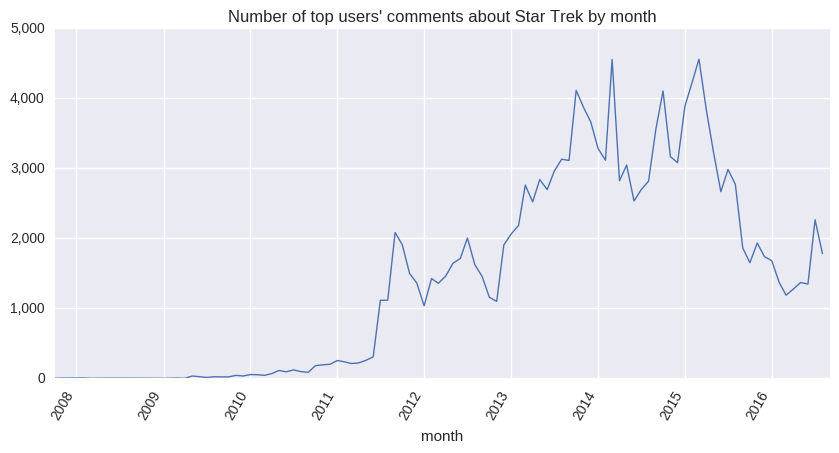

In [49]:
ax = top_reddit_by_month.plot(
    figsize=(10,5),
    xlim=('2007-10-01', '2016-08-31'),
#     xticks=top_reddit_by_month.index,
    rot=60,
    title='Number of top users\' comments about Star Trek by month',
)
formatter = matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ','))
ax.get_yaxis().set_major_formatter(formatter)

/home/antonio/.virtualenvs/nandi/lib/python3.4/site-packages/matplotlib/scale.py:101: RuntimeWarning: invalid value encountered in less_equal
  a[a <= 0.0] = 1e-300


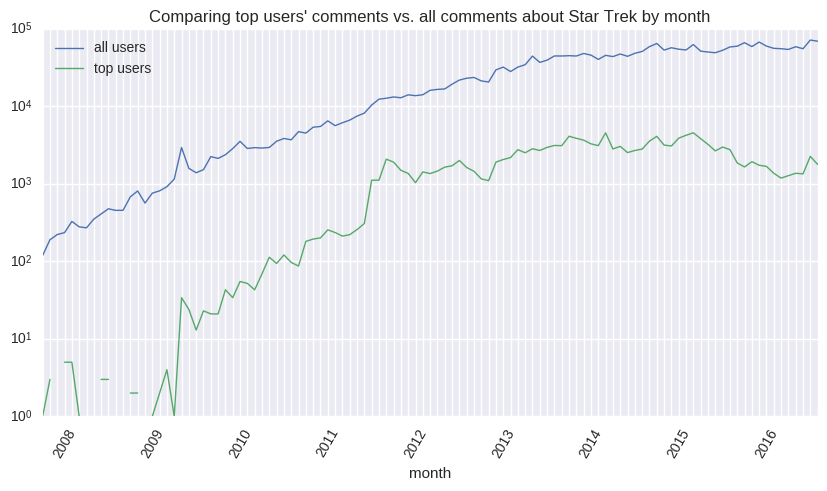

In [39]:
ax = comp_top_comments_by_month.plot(
    figsize=(10,5),
    xlim=('2007-10-01', '2016-08-31'),
    xticks=comp_top_comments_by_month.index,
    rot=60,
    title='Comparing top users\' comments vs. all comments about Star Trek by month',
)
formatter = matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ','))
ax.get_yaxis().set_major_formatter(formatter)
ax.set_yscale('log')

## Histogram

### Keywords

In [50]:
keywords_dict = {}
for keyword in keywords:
    keyword_df = top_reddit_df[top_reddit_df['body'].str.contains(keyword)]
    count = keyword_df['body'].str.count(keyword).sum()
    keywords_dict[keyword] = count

In [51]:
keywords_counter = Counter(keywords_dict)

In [52]:
keywords_counter.most_common()

[('star trek', 37941),
 ('picard', 15379),
 ('kirk', 14310),
 ('klingon', 12573),
 ('spock', 10738),
 ('vulcan', 9964),
 ('orion', 8667),
 ('romulan', 8521),
 ('mccoy', 3664),
 ('prime directive', 2133),
 ('scotty', 2046),
 ('pike', 1685),
 ('crusher', 1582),
 ('nero', 1472),
 ('uhura', 1287),
 ('sulu', 1172),
 ('stardate', 657),
 ('star fleet', 528),
 ('sarek', 458),
 ('llap', 374),
 ('kobayashi maru', 275),
 ('resistance is futile', 163),
 ('chekhov', 143),
 ('khaaa+n', 122),
 ('starship enterprise', 120),
 ('live long and prosper', 114),
 ('delta vega', 92),
 ('transporter beam', 74),
 ('nurse chapel', 65),
 ('the needs of the many outweigh the needs of the few', 61),
 ('space,? the final frontier', 46),
 ("i'm a doctor,? not a", 36),
 ('vulcan salute', 32),
 ('beam me up,? scotty', 28),
 ('highly illogical', 27),
 ('nuclear wessels', 26),
 ('to boldly go where no man has gone before', 16),
 ('i have been and always shall be your friend', 8),
 ('set phasers to stun', 7),
 ("i'm givi

In [53]:
keywords_sr = pd.Series(keywords_dict)

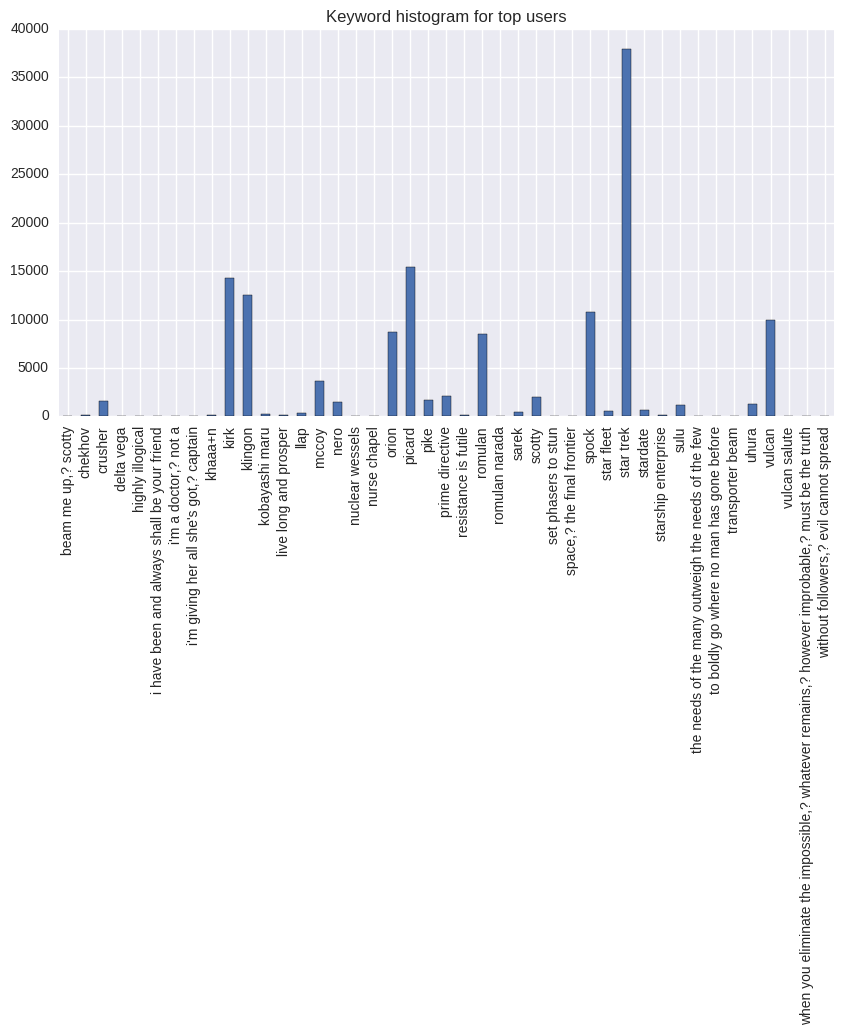

In [60]:
keywords_sr.plot(
    kind='bar',
    figsize=(10, 5),
    title='Keyword histogram for top users',
)

### Other words

In [62]:
%%time

text_ = ''
for x in top_reddit_df['body']:
    text_ += x + ' '

list_ = [
    w
    for w in nltk.word_tokenize(text_)
    if w not in stopwords.words('english') and w not in string.punctuation
]

counter_ = Counter(list_)

CPU times: user 27min 54s, sys: 1min 51s, total: 29min 45s
Wall time: 29min 47s


In [63]:
counter_.most_common(100)

[("'s", 119198),
 ("n't", 84664),
 ("''", 58254),
 ('``', 51910),
 ('trek', 44106),
 ('would', 43286),
 ('like', 40898),
 ('star', 39429),
 ('one', 32506),
 ('gt', 32043),
 ('time', 24287),
 ('get', 23691),
 ('think', 23489),
 ('...', 23284),
 ('even', 23028),
 ('people', 22912),
 ('http', 20629),
 ("'re", 20425),
 ('could', 19602),
 ('really', 19547),
 ('also', 18816),
 ('see', 18455),
 ("'m", 17289),
 ('good', 16943),
 ('much', 16684),
 ('know', 16191),
 ('first', 15944),
 ('well', 15219),
 ('way', 15081),
 ('make', 14489),
 ('still', 13940),
 ('new', 13927),
 ('show', 13663),
 ("'ve", 13660),
 ('kirk', 13453),
 ('picard', 13130),
 ('back', 12120),
 ('something', 11724),
 ("'d", 11676),
 ('going', 11395),
 ('never', 11141),
 ('want', 11078),
 ('doctor', 11049),
 ('series', 10919),
 ('go', 10804),
 ('federation', 10494),
 ('ship', 10358),
 ('though', 10216),
 ('better', 10102),
 ('episode', 10042),
 ('things', 10008),
 ('actually', 9929),
 ('say', 9856),
 ('got', 9797),
 ('spock', 971

### Sentiment analysis

In [64]:
%%time

sentiment_list = []
for x in top_reddit_df['body']:
    tb = TextBlob(x)
    sentiment_list.append((x, tb.sentiment.polarity, tb.sentiment.subjectivity))

CPU times: user 1min 34s, sys: 37.3 ms, total: 1min 34s
Wall time: 1min 34s


In [65]:
sentiment_df = pd.DataFrame(sentiment_list, columns=['body', 'sentiment', 'subjectivity'])

In [66]:
sentiment_df.head()

,body,sentiment,subjectivity
0,"he's alright, but he's no james t. kirk.",0.00,0.00
1,star trek ftw!,0.00,0.00
2,star trek? any star trek? - - star trek ii: ...,0.62,0.32
3,spock is one of the best sci-fi characters eve...,1.00,0.30
4,"captain pike from ""the cage""",0.00,0.00


In [67]:
sentiment_df['sentiment'].mean()

0.079853428697543249

In [68]:
sentiment_df['subjectivity'].mean()

0.42854619825125734

# Saving data

In [ ]:
# nx.write_gexf(graph, 'user_graph_2.gexf')